<h1> <font color="red">Projet Text Mining :</font></h1>

In [1]:
import math
import nltk as nk
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as kmeans
from nltk.corpus import reuters 
from nltk import word_tokenize
from nltk.corpus import reuters 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.stem.porter import PorterStemmer
import re
from scipy.spatial.distance import pdist, euclidean
from sklearn.decomposition import non_negative_factorization 
from sklearn.decomposition import NMF
from scipy.stats import entropy
from math import log, e
from sklearn.metrics.pairwise import polynomial_kernel as pk
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics.pairwise import rbf_kernel as rbf
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import pandas as pd
from sklearn.metrics import log_loss as sk_entropy
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix
import pymf3 
from functools import reduce
from numba import njit, jit
import argparse
import time
import csv




<h3>Introduction de la bibliotheque NLTK (Natural Language Toolkit) :</h3>
<p>Traditionnellement, nous devions télécharger la collection et analyser les multiples fichiers SGML afin de reconstruire la base de données d'origine. Heureusement, cette étape est beaucoup plus facile grâce à la bibliothèque NLTK, qui dispose déjà du corpus de reuters, ainsi que de diverses fonctions utiles qui faciliteront le travail avec la base de données.</p>

<p>Cet ensemble de données comprend 9 603 documents pour le training et 3 299 pour les tests, chaque document a un identifiant unique que nous pouvons utiliser pour accéder à son contenu, nous pouvons choisir d'accéder au dictionnaire document ou au contenu brut, et la fonctionnalité la plus puissante est la possibilité d'accéder documents en précisant la catégorie à laquelle ils appartiennent </p>

<h3> </h3>

<h3 ><font color="blue"> <b> - Liste de fonctions definis dans ce projet et leur utilité :</b></font> </h3>

 * <b>tokenize(text):</b><p>Appliquer le stemming, le tokenization,l'élimination de chiffres et de mots d'une longueur inférieure à 3, sur un string de texte </p>
 * <b>PlotClusters(docs,labels):</b><p>visualiser les données stockées dans la variable conformément aux étiquettes, en utilisant la PCA pour réduire les dimensions</p>
 * <b>show_clusters(matr):</b><p>Calculer la matrice de partition</p>
 * <b>calcul_Htest(matr):</b><p>Calculer la vraie matrice de partition</p>
 * <b>calcul_entropy(matr):</b><p>Calculer l'entropy d'une matrice </p>
 * <b>calcul_purity(y_pred,y_true):</b><p>Calculer la purete d'une matrice </p>
 * <b>SymNMF:</b><p>Notre implémentation de l'algorithme NMF symétrique basé sur des règles d'adaptation mentionnées dans le cours.</p>
 * <b>TriNMF:</b><p>Notre implémentation de l'algorithme Tri-NMF basé sur des règles d'adaptation mentionnées dans le cours.
 
<h3><b> <font color="blue"> - Liste de fonctions prédifinis utilisés :</font></b></h3>

 * <b>NMF/non_negative_factorization:</b><p>Appliquer le NMF sur une matrice de données  </p>
 * <b>CounteVectorizer :</b><p>Eliminer les "stop-words" et Transformer la matrice de données a une matrice d'occurences et mettre tous les mots </p>
 * <b>accuracy_score():</b><p>Calculer la purete</p>
 * <b>log_loss: </b><p> Calculer l'entropy </p>
 
 
    
    
    


<h5><b>toutes les fonctions sont définies dans cette cellule :</b></h5>

In [3]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text));
    words = [word for word in words if word not in cachedStopWords]
    tokens =(list(map(lambda token: PorterStemmer().stem(token),words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens =list(filter(lambda token:p.match(token) and len(token)>=min_length,tokens));
    return filtered_tokens

def PlotClusters(docs,labels):  
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(docs)
    principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2','principal component 3'])
    principalDf['labels']=labels
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111,projection='3d')
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title(' PCA de 3 composants ',fontsize=20)
    targets = [0,1,2,3]
    cats =["corn","interest","ship","gold"]
    colors = ['r','g','b','y']
    for target , color in zip(targets,colors):
        indicesToKeep = principalDf['labels'] == target 
        ax.scatter(principalDf.loc[indicesToKeep,'principal component 1'],principalDf.loc[indicesToKeep,'principal component 2'],principalDf.loc[indicesToKeep,'principal component 3'],c =color,s=30)
        ax.legend(targets)
        ax.grid(cats)        
    return principalDf 



def show_clusters(matr):
    for i ,r in enumerate(matr):
        max_value = np.amax(matr[i])
        for j, c in enumerate(matr[i]):
            if matr[i][j] != max_value:
                matr[i][j]=0
            else:
                matr[i][j]=1            
    return matr
        
def calcul_Htest(matr):
    l = np.size(matr,0)
    H_test = np.zeros((l,1))
    for i ,r in enumerate(matr):
        for j, c in enumerate(matr[i]):
            if matr[i][j] == 1:
                H_test[i] = j 
           
    return H_test


def calcul_entropy(labels, base=None):
    """ Calculer l'entropie de la distribution des étiquettes """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    valeur,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0

    # Calcul de l' entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

def calcul_purity(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def frobenius(A, B):
    return np.linalg.norm(A-B, 'fro')

def DaviesBouldin(X, labels):
    n_cluster = len(np.bincount(labels))
    cluster_k = [X[labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([euclidean(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / euclidean(centroids[i], centroids[j]))

    return(np.max(db) / n_cluster)


def SymNMF(X,r,nb_iterations,critere_stop,beta):
    m = X.shape[0]
    H = np.random.rand(m, r)
    H_t = np.random.rand(r,m)
    S = np.random.rand(r,r)
    
   
    
    errs = np.zeros((nb_iterations,1))
    
    for i in range(nb_iterations):
        
      #mise a jour la matrice H
       for i in range(np.size(H, 0)):
        for j in range(np.size(H, 1)):
             H[i, j] = H[i,j] * (1 - beta + (beta * ((X @ H @S)[i,j])/(H @ S @ np.transpose(H) @ H @ S )[i,j]) )
             
                
      #mise a jour la matrice S
       for i in range(np.size(S, 0)):
        for j in range(np.size(S, 1)):
             S[i, j] = S[i,j] * ((np.transpose(H) @ X @ H)[i,j]/(np.transpose(H) @ H @ S @ np.transpose(H) @ H)[i,j])
                
        #errs[t,0] = (X-(H @ (np.transpose(H))*S))** 2
        #if(errs[t,0]<=critere_stop): return H 
     
    return H




def TriNMF(X,r,k,nb_iterations,critere_stop):
    p = X.shape[0]
    n= X.shape[1]
    F = 100 * np.random.rand(p, k)
    S = 100 * np.random.rand(k,r)
    G = 100 * np.random.rand(n,r)
    
    
    for i in range(nb_iterations):
        # mise a jour de la matrice G
        numerator= reduce(np.dot, [X.T, F, S])
        denominator= reduce(np.dot, [G, G.T, numerator])
        mu_G= np.sqrt(numerator/denominator)
        G= G * mu_G

        # mise a jour de la matrice F
        numerator= reduce(np.dot, [X, G, S.T])
        denominator= reduce(np.dot, [F, F.T, numerator])
        mu_F= np.sqrt(numerator/denominator)
        F= F * mu_F

        # mise a jour de la matrice S
        enumrator= FtXG= reduce(np.dot, [F.T, X, G])
        FtF= np.dot(F.T, F)
        GtG= np.dot(G.T, G)
        denominator=reduce(np.dot, [FtF, S, GtG])
        mu_S= np.sqrt(enumrator/denominator)
        S= S * mu_S
   
        
    return F 

    





<h3>Definition des variables que nous allones utiliser :</h3>

In [4]:
#nous avons choisi les catégories avec un nombre relativement petit de documents afin de minimiser -
#la probabilité que l'un d'entre eux puisse appartenir à plusieurs catégories"""

#les catégories qu'on va utiliser
categories_choisis =["corn","interest","ship","gold"]
    
#chaque numéro de ce vecteur correspond à une étiquette
vecteur_categories =[0,1,2,3]
    
#récupération des ids des documents pour chaque catégorie
corn_documents_ids = reuters.fileids("corn")
interest_documents_ids = reuters.fileids("interest")
dlr_documents_ids = reuters.fileids("ship")
gold_documents_ids=reuters.fileids("gold")
    
#listes des documents train et test pour chaque catégorie
#corn
corn_documents_contenu_train =[]
corn_documents_contenu_test =[]
#interest    
interest_documents_contenu_train =[]
interest_documents_contenu_test=[]
#gold
gold_documents_contenu_train=[]
gold_documents_contenu_test=[]
#dlr 
dlr_documents_contenu_train=[]
dlr_documents_contenu_test=[]

#des variables contenants la liste des documents par categorie
corn_documents_contenu =[]
interest_documents_contenu=[]
gold_documents_contenu =[]
dlr_documents_contenu =[]

#variable contenant le contenu de touts les documents
documents_contenu =[]
cachedStopWords = stopwords.words("english")   

In [5]:
#recuperation des données de train pour chaque classe
nombre_documents_train =75
i=0        
for doc_id in corn_documents_ids:
    if doc_id.startswith("train"):
        corn_documents_contenu_train.append(reuters.raw(doc_id))
        i=i+1
    if (i>=nombre_documents_train):
        i=0
        break
            
for doc_id in interest_documents_ids:
    if doc_id.startswith("train"):
        interest_documents_contenu_train.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_train):
            
        i=0
        break       
for doc_id in dlr_documents_ids:
    if doc_id.startswith("train"):
        dlr_documents_contenu_train.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_train):
        i=0
        break
            
for doc_id in gold_documents_ids:
    if doc_id.startswith("train"):
        gold_documents_contenu_train.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_train):
        i=0
        break
       
 #recuperation des données de test pour chaque classe 
nombre_documents_test=25   
i=0        
for doc_id in corn_documents_ids:
    if doc_id.startswith("test"):
        corn_documents_contenu_test.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_test):
        i=0
        break
             
for doc_id in interest_documents_ids:
    if doc_id.startswith("test"):
        interest_documents_contenu_test.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_test):  
        i=0
        break
        
for doc_id in dlr_documents_ids:
    if doc_id.startswith("test"):
        dlr_documents_contenu_test.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_test):
        i=0
        break
            
for doc_id in gold_documents_ids:
    if doc_id.startswith("test"):
        gold_documents_contenu_test.append(reuters.raw(doc_id))
        i=i+1
                     
    if (i>=nombre_documents_test):
        i=0
        break     
    
corn_documents_contenu_train.extend(corn_documents_contenu_test)
corn_documents_contenu=corn_documents_contenu_train
  
interest_documents_contenu_train.extend(interest_documents_contenu_test)
interest_documents_contenu=interest_documents_contenu_train
    
dlr_documents_contenu_train.extend(dlr_documents_contenu_test)
dlr_documents_contenu=dlr_documents_contenu_train
    
gold_documents_contenu_train.extend(gold_documents_contenu_test)
gold_documents_contenu=gold_documents_contenu_train
    
corn_documents_contenu.extend(interest_documents_contenu)
corn_documents_contenu.extend(dlr_documents_contenu)
corn_documents_contenu.extend(gold_documents_contenu)
    
documents_contenu = corn_documents_contenu
    
#preparation des données : la lemmatisation ("Porter stemming")et l’elimination des mots frequents ("stop words")
words_list=[]
for i in range(len(documents_contenu)-1):
    words_list = tokenize(documents_contenu[i])
    documents_contenu[i] = ' '.join(word for word in words_list)
      
#transformer les documents en matrice d'occurences, eliminer les chiffres et mettre toutes les mots en miniscule
cv = CountVectorizer(lowercase=True,stop_words='english',token_pattern='[a-zA-Z]+')
cv_fit=cv.fit_transform(documents_contenu)
    
#la variable reuters_data avant d'appliquer la fonction tfidf
reuters_data = pd.DataFrame(cv_fit.toarray(), columns=cv.get_feature_names())
#print(reuters_data)
    
#la variable reuters_labels
labels_array = np.zeros(shape=(400,1))
for i in range(400):  
    if i<200 and i>=100:
        labels_array[i]=vecteur_categories[1]
    if i<300 and i>=200:
        labels_array[i]=vecteur_categories[2]
    if i<400 and i>=300:
        labels_array[i]=vecteur_categories[3] 
reuters_labels = pd.DataFrame({'Document_Label': labels_array[:, 0]})
#print(reuters_labels)   

<b>Application de la TF-IDF : </b>
<p>Terme Fréquence Inverse du Document La fréquence est une statistique numérique qui montre l'importance d'un mot pour un corpus.</p>

In [6]:
#application de tfidf sur l'ensemble des données 
tfidf_tr = TfidfTransformer()
tfidf_mat = tfidf_tr.fit_transform(cv_fit)
  
#variable reuters4
reuters4 = pd.DataFrame(tfidf_mat.toarray(),columns=cv.get_feature_names())

#variable labels4
labels4 = reuters_labels

#print(reuters4)
#print(labels4)


In [7]:
#creation des variables reut_train et reut_test
    
#variable reut_train
reut_train_corn=reuters4.iloc[0:75,:]
reut_train_interest=reuters4.iloc[100:175,:]
reut_train_dlr=reuters4.iloc[200:275,:]
reut_train_gold=reuters4.iloc[300:375,:]
    
reut_train = reut_train_corn.append(reut_train_interest)
reut_train = reut_train.append(reut_train_dlr)
reut_train = reut_train.append(reut_train_gold)
    
#variable label_train
label_arr = np.zeros((300,1))
label_arr[75:150]=1
label_arr[150:225]=2
label_arr[225:300]=3
    
label_train = pd.DataFrame({'labels': label_arr[:, 0]})
#print(label_train)
   
#variable reut_test
reut_test_corn=reuters4.iloc[75:100,:]
reut_test_interest=reuters4.iloc[175:200,:]
reut_test_dlr=reuters4.iloc[275:300,:]
reut_test_gold=reuters4.iloc[375:400,:]
       
reut_test = reut_test_corn.append(reut_test_interest)
reut_test = reut_test.append(reut_test_dlr)
reut_test = reut_test.append(reut_test_gold)

#variable label_test
label_arr = np.zeros((100,1))
label_arr[0:25]=1
label_arr[25:50]=2
label_arr[50:100]=3
label_test = pd.DataFrame({'labels': label_arr[:, 0]})
#print(label_test)
    

#print(reut_train)
#print(reut_test)



<h3><b> Visualisation des données stockés dans reuters4 :</b></h3>

,principal component 1,principal component 2,principal component 3,labels
0,-0.301219,-0.247972,-0.089272,0.0
1,-0.052268,0.009535,0.052110,0.0
2,-0.363297,-0.302608,-0.073434,0.0
3,-0.233691,-0.217864,-0.103094,0.0
4,-0.291173,-0.190382,-0.042244,0.0
5,-0.166492,-0.067442,-0.026992,0.0
6,-0.053006,-0.016142,0.049933,0.0
7,-0.253595,-0.189129,0.024363,0.0
8,-0.201982,-0.149166,0.001199,0.0
9,-0.190916,-0.196977,-0.094224,0.0


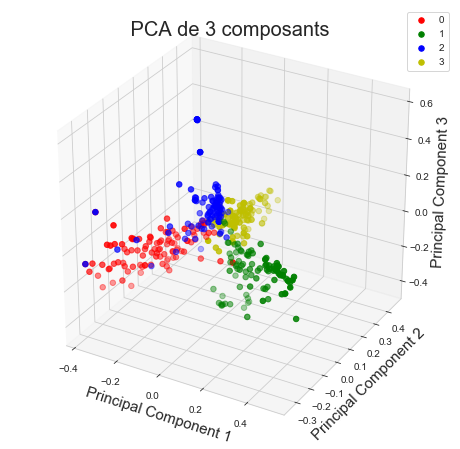

In [8]:
#visualisation des données en utilisant la fonction PlotClusters
PlotClusters(reuters4,labels4)

<h2><b>Partie 1: NMF de base </b> </h2>

<h4><font color=""> Questions: 2 / 2.a / 2.b  </font></h4>

In [9]:
    #application de la factorisation NMF a la matrice reut_train
    model = NMF(n_components=4,init='nndsvd')
    W = model.fit_transform(reut_train.to_numpy())
    H = model.components_
    print(W.shape)
    print(H.shape)
    
    #nous pouvons utiliser une autre fonction de sklearn pour calculer le NMF, appelée non_negative_factorization
    #W2, H2, n_iter = non_negative_factorization(reut_train.to_numpy(), n_components=4, init='random', random_state=0)
   
    #variable W_train
    W_train = W
    print(W_train)
    
    #transformation de la matrice de partition a une vraie matrice de partition 
    ma=show_clusters(np.array(W_train))
    print(ma)
    H_Test = calcul_Htest(ma)
    #print(H_Test)
    
    

(300, 4)
(4, 3923)
[[0.21391459 0.         0.         0.        ]
 [0.04679497 0.00166486 0.01207453 0.00097955]
 [0.27217581 0.         0.         0.        ]
 ...
 [0.02583489 0.01401607 0.08287903 0.        ]
 [0.02852236 0.07722807 0.12090537 0.01625444]
 [0.         0.         0.28180783 0.        ]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


<h4> Calcul des indices externes entropy et purity : </h4>

In [10]:
#Entropy

#print( calcul_entropy(H_Test))
print(sk_entropy(H_Test,W_train))

0.3193066026642915


In [11]:
#purity

#print(calcul_purity(label_train.to_numpy(),H_Test))
print(accuracy_score(label_train.to_numpy(),H_Test))

0.47333333333333333


<h4> Calcul des indices internes Davies Bouldin et CH de Clainsky et Harabsz : </h4>

In [12]:
#indice de Davies et Bouldin
print(davies_bouldin_score(reut_train.to_numpy(), H_Test)) 

4.6918978395409585


C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [13]:
#l’indice CH de Calinsky et Harabsz
print(metrics.calinski_harabaz_score(reut_train.to_numpy(), H_Test))

6.973558754447006


C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,principal component 1,principal component 2,principal component 3,labels
0,-0.239746,-0.288356,-0.039627,0.0
1,-0.059923,-0.019967,-0.013890,0.0
2,-0.284643,-0.361708,0.025756,0.0
3,-0.189386,-0.240787,-0.035229,0.0
4,-0.243132,-0.246312,-0.039634,0.0
5,-0.147132,-0.085960,-0.064372,0.0
6,-0.053058,-0.046409,0.012183,0.0
7,-0.218178,-0.238344,-0.112451,0.0
8,-0.172121,-0.198045,-0.007088,0.0
9,-0.154233,-0.225521,0.015620,0.0


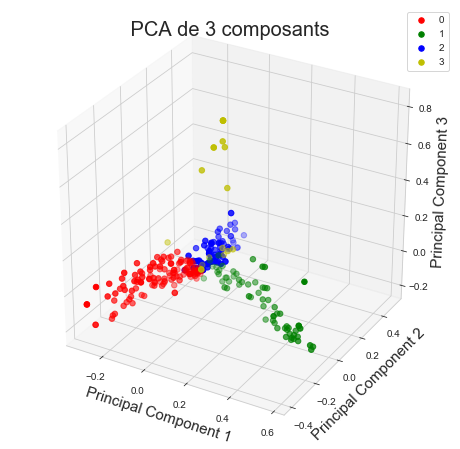

In [14]:
#visualisation des données avec les étiquettes obtenues
PlotClusters(reut_train,H_Test)

<h2><b> Partie 2 Tri NMF :</b></h2>

C:\Users\HAITAM\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide
C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


[[0.02107452 0.03960687 0.01973262 0.02103412]
 [0.02569924 0.01574759 0.02545639 0.0066003 ]
 [0.02936195 0.037248   0.03581452 0.0184386 ]
 ...
 [0.00017981 0.01313468 0.05264461 0.04469641]
 [0.03682187 0.0300646  0.01105976 0.00541057]
 [0.00642907 0.00183847 0.01065303 0.03648339]]
La purete =  0.235
L'entropy =  0.024260151319601207
indice de Davies et Bouldin =  14.346611467560695


C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


indece CH de Calinsky et Harabsz 1.0290059646949354


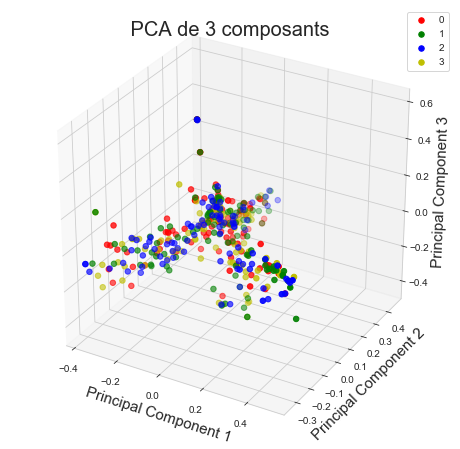

In [15]:
#application de TriNMF a la matrice reuters4
TriNMF_F=TriNMF(reuters4.to_numpy(),4,4,2,0.01)
#la matrice des clusters
print(TriNMF_F)

#calcul de la vraie matrice de partition Tri_Labels a partir de la matrice de partition TriNMF_H
Tri_Labels=calcul_Htest(show_clusters(TriNMF_F))


#visualisation des données
PlotClusters(reuters4.to_numpy(),Tri_Labels)

#calcul des indices externes
#calcul de la purete
print("La purete = ",accuracy_score(labels4.to_numpy(),Tri_Labels))

#calcul de l'entropy
print("L'entropy = ",sk_entropy(Tri_Labels,TriNMF_F))


#calcul des indices internes
#indice de Davies et Bouldin
print("indice de Davies et Bouldin = ",davies_bouldin_score(reuters4.to_numpy(), Tri_Labels)) 
#l’indice CH de Calinsky et Harabsz
print("indece CH de Calinsky et Harabsz",metrics.calinski_harabaz_score(reuters4.to_numpy(), Tri_Labels))

<h2> <b>Partie 3 : NMF Symetrique</b> </h2> 

<h4>1- Calcul de la matrice de gram en utilisant le RBFKernel de sklearn :</h4>

In [16]:
#calcul de la matrice Gram a partir de reut_test 
K_Test = rbf(reut_test.to_numpy(),reut_test.to_numpy(),1)
print(K_Test)

[[1.         0.1712829  0.15258544 ... 0.14399357 0.14925116 0.14577804]
 [0.1712829  1.         0.15284913 ... 0.1830629  0.14224305 0.14226429]
 [0.15258544 0.15284913 1.         ... 0.14286187 0.14100131 0.13658432]
 ...
 [0.14399357 0.1830629  0.14286187 ... 1.         0.1676195  0.1610954 ]
 [0.14925116 0.14224305 0.14100131 ... 0.1676195  1.         0.3950216 ]
 [0.14577804 0.14226429 0.13658432 ... 0.1610954  0.3950216  1.        ]]


<h4>2- Application de le NMF symétrique :</h4>

<p>Le code pour implémenter le NMF symétrique provient de ce dépôt github <b>https://github.com/canerturkmen/nmflib</b>, qui utilise 4 classes différentes définies dans cette cellule </p>

In [17]:
#Implementation de NMF symmetrique
#Source :
class BaseNMF:
   

    maxiter = 10000
    stopconv = 1e-4

    def __init__(self, X, k, **kwargs):
     

        #TODO: ClusterNMF can have negative entries!
        if X.min() < 0:
            raise Exception("The matrix cannot have negative entries")

        if kwargs.get("maxiter"):
            self.maxiter = kwargs.get("maxiter")

        if kwargs.get("stopconv"):
            self.stopconv = kwargs.get("stopconv")

        self.X = X
        self.k = k

class NMFResult:
   
    convgraph = None # an array of objective function values to plot convergence
    matrices = None # a python **list** of factorizing matrices
    objvalue = None # the final value of the objective function
    converged = None

    def __init__(self, matrices, convgraph=None, objvalue=None, converged=None):
        self.matrices = matrices
        self.convgraph = convgraph
        self.objvalue = objvalue
        self.converged = converged


class ClusterNMF(BaseNMF):
  

    def predict(self):
       
        # Fresh start, as described in the paper
        pdist = 1e9 #very large number
        cl = KMeans(n_clusters=self.k).fit_predict(self.X)

        # initialize H
        indices = cl
        indptr = range(len(indices)+1)
        data = np.ones(len(indices))
        H = csr_matrix((data, indices, indptr)).todense()

        D_ = np.mat(np.diag(1 / H.sum(0).astype('float64'))) # D^-1

        # initialize the factorizing matrix
        G = H + .2

        # we will work with the transpose of the matrix, X is now (n_features, n_obs)
        X = np.mat(self.X.T)

        # calculate X*X^T in advance (pairwise inner product matrix)
        XTX = X.T * X
        XTXp = (np.abs(XTX) + XTX) / 2
        XTXn = (XTX - np.abs(XTX)) / 2

        # flags and counters for checking convergence
        dist = 0
        converged = False
        convgraph = np.zeros(int(self.maxiter / 10))
        
        for i in range(self.maxiter):

            # multiplicative update step, Euclidean error reducing

            factor = np.divide(XTXp*G + G*G.T*XTXn*G, XTXn*G + G*G.T*XTXp*G)

            G = np.multiply(G, factor)

            # every 10 iterations, check convergence
            if i % 10 == 0:
                dist = frobenius(X, X*G*G.T)
                convgraph[int(i/10)] = dist

                if pdist - dist < self.stopconv:
                    converged = True
                    break

                pdist = dist

        return NMFResult((np.array(G),), convgraph, dist, converged)
    
    
    
class NMFClustering:
  
    def __init__(self, n_clusters=4, algorithm="cluster", options={}, maxiter=1000, stopconv=.001):
      
        self.k =4
        self.nmf_class = None
        self.kwargs = {} # keyword arguments that will be passed to NMF constructor

        filter_dict = lambda x, ls : {k: x[k] for k in ls if x.get(k)}

        if algorithm == "cluster":
            self.nmf_class = ClusterNMF

        else:
            raise ValueError("Unrecognized algorithm provided")

        self.kwargs.update({"maxiter": maxiter, "stopconv": stopconv})

    def fit_predict(self, X):
      

        nmf = self.nmf_class(X, self.k, **self.kwargs) # set up the algorithm

        result = nmf.predict()

        W = result.matrices[0]
        W = np.nan_to_num(W)
        # W /= np.linalg.norm(W, 2, 0)

        return np.argmax(result.matrices[0], 1), result

In [18]:
#application de la sym nmf a la matrice de gram
SymNmf = NMFClustering('cluster')

#des labels obtenus
labels_obtenus=SymNmf.fit_predict(K_Test)

print(labels_obtenus[0])





[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


<h4>3- Visualisation de reut_test avec les nouvelles étiquettes : </h4>

,principal component 1,principal component 2,principal component 3,labels
0,0.093035,0.040442,-0.103430,1
1,-0.111980,-0.050705,-0.029493,1
2,0.021015,-0.095820,0.003718,1
3,-0.262930,0.277423,-0.046693,1
4,-0.120048,0.041199,-0.063780,1
5,-0.401628,0.156835,-0.148867,1
6,-0.169461,-0.010033,-0.125472,1
7,-0.245541,-0.019557,-0.176314,1
8,-0.222470,-0.051836,-0.179496,1
9,-0.188040,-0.040201,-0.138263,1


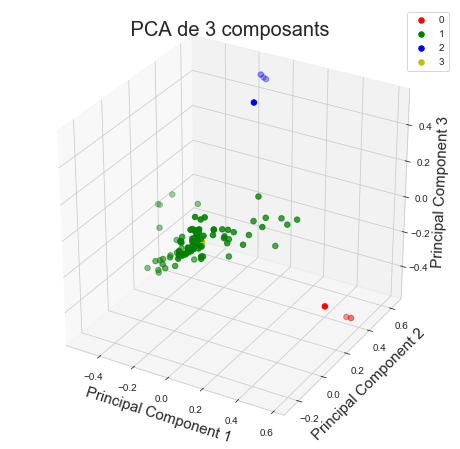

In [19]:
PlotClusters(reut_test,labels_obtenus[0])

<h4>4-1- Calcul des indices externes entropy et purete : </h4>

In [20]:
#calcul de la pureté pour la matrice obtenu
print(calcul_purity(label_test.to_numpy(),labels_obtenus[0]))
print(accuracy_score(label_test.to_numpy(),labels_obtenus[0]))

0.58
0.31


In [21]:
#Entropy
#print(sk_entropy(labels_obtenus[0]),reut_test.to_numpy())

<h4>4-2- Calcul des indices internes: </h4>

In [22]:
#indice de Davies et Bouldin
#print(davies_bouldin_score(reut_test.to_numpy(), labels_obtenus[0]))
print(davies_bouldin_score(reut_train.to_numpy(), H_Test)) 

4.6918978395409585


C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [23]:
#l’indice CH de Calinsky et Harabsz
print(metrics.calinski_harabaz_score(reut_test.to_numpy(), labels_obtenus[0]))

2.3140279547617415


<h4>Application de le kernel polynomial , après on répète les mêmes opérations: NMF symetrique et visualisation, indices internes et externes</h4>

[[3.         2.11778065 2.05998472 ... 2.03100669 2.04893762 2.03716495]
 [2.11778065 3.         2.06084804 ... 2.15103725 2.02489096 2.02496561]
 [2.05998472 2.06084804 3.         ... 2.02706149 2.02050697 2.00459343]
 ...
 [2.03100669 2.15103725 2.02706149 ... 3.         2.10697063 2.08712074]
 [2.04893762 2.02489096 2.02050697 ... 2.10697063 3.         2.53559258]
 [2.03716495 2.02496561 2.00459343 ... 2.08712074 2.53559258 3.        ]]
(array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3,
       1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), <__main__.NMFResult object at 0x000001A45418DCF8>)
0.08
3.1923981376402364
3.3600099240829904


C:\Users\HAITAM\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


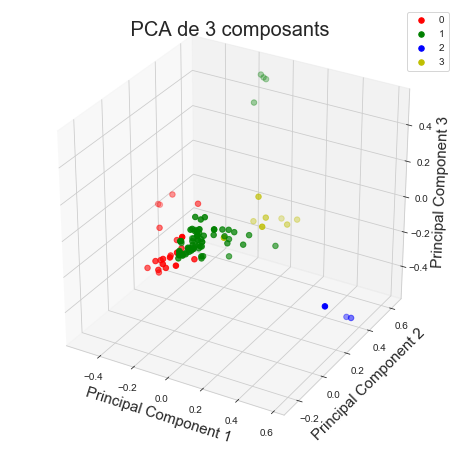

In [24]:
#calcul de la matrice Gram en utilisant le kernel polynomial de sklearn 
K_Test = pk(reut_test.to_numpy(),reut_test.to_numpy(),1,1,2)
print(K_Test)

#Application de sym NMF
SymNmf = NMFClustering('cluster')
sym2 = SymNmf.fit_predict(np.transpose(K_Test))
print(sym2)

#Visualisation des données
PlotClusters(reut_test,sym2[0])

#Calcul de la purete
print(accuracy_score(label_test.to_numpy(),sym2[0]))

#Calcule de l'entropy
#Entropy
#print(sk_entropy(labels_obtenus[0],labels_obtenus[1]))
#indice de Davies et Bouldin
#print(davies_bouldin_score(reut_test.to_numpy(), labels_obtenus[0]))
print(davies_bouldin_score(reut_test.to_numpy(), sym2[0])) 
print(metrics.calinski_harabaz_score(reut_test.to_numpy(), sym2[0]))

<h3><b>Comparaison des resultats :</b></h3>
<h4><b>Basé sur le score de pureté :</b></h4>  Le NMF de base est le meilleur avec un score compris entre 47% et 74% selon la fonction purete utilisée, ce qui est meilleur que les 2 autres variations.triNMF n'a pas atteint un score de précision supérieur à 28%, SymNMF avec le noyau rbf et le noyau polynomial qui n’ont pas atteint un score supérieur à 34%.

<h4><b>Basé sur le score d'entropy: </b></h4>le NMF de base a obtenu le score le plus bas d’environ 0,34, ce qui donne le meilleur, le plus bas l’entropie le mieux,un faible score d'entropie signifie un système moins désordonné et une meilleure qualité de clustering.

<h4><b>Basé sur l'indice de Davies-Bouldin </b></h4>
NMF de Base = 4.69<br>
Sym NMF avec RBFKernel = 4.69<br>
Sym NMF avec PolynomialKernel = 3.46<br>
TriNMF = 14.34<br>

<h4><b>Basé sur l'indice de CH de Calinsky et Harabsz </b></h4> 
NMF de Base = 6.97<br>
Sym NMF avec RBFKernel = 2.31<br>
Sym NMF avec PolynomialKernel = 3.51<br>
TriNMF = 1.029<br>

